In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import re
import emoji
import datasets

RANDOM_SEED = 69

c:\Users\rey32\AppData\Local\Programs\Python\Python312\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [13]:
def clean_tweet(tweet):
    tweet = re.sub(r'http\S+', '', tweet)  # Remove URLs
    tweet = re.sub(r'@[A-Za-z0-9_]+', '', tweet)  # Remove @ mentions
    tweet = re.sub(r'#[A-Za-z0-9_]+', '', tweet)  # Remove hashtags
    tweet = re.sub(r'[^A-Za-z\s.,!?;:\'\"-]', '', tweet)  # Remove non-alphabetic characters
    tweet = tweet.lower().strip()  # Lowercase and remove leading/trailing spaces
    return tweet

def clean_reddit_comment(comment):
    comment = re.sub(r'http\S+', '', comment)  # Remove URLs
    comment = re.sub(r'(u\/|r\/)[A-Za-z0-9_]+', '', comment)  # Remove Reddit mentions
    comment = re.sub(r'#[A-Za-z0-9_]+', '', comment)  # Remove hashtags
    comment = re.sub(r'[^A-Za-z\s.,!?;:\'\"-]', '', comment)  # Remove non-alphabetic characters
    comment = comment.lower().strip()  # Lowercase and remove leading/trailing spaces
    return comment

def clean_reddit_comment_with_emoji(comment):
    comment = re.sub(r'http\S+', '', comment)  # Remove URLs
    comment = re.sub(r'(u\/|r\/)[A-Za-z0-9_]+', '', comment)  # Remove Reddit mentions
    comment = re.sub(r'#[A-Za-z0-9_]+', '', comment)  # Remove hashtags
    comment = ''.join(char for char in comment if char.isalnum() or char.isspace() or char in ".,!?;:\'\"-()[]{}" or emoji.is_emoji(char))  # Keep only alphanumeric characters, spaces, punctuation and emojis
    comment = comment.lower().strip()  # Lowercase and remove leading/trailing spaces
    return comment

def clean_instagram_comment_without_emoji(comment):
    comment = re.sub(r'http\S+', '', comment)  # Remove URLs
    comment = re.sub(r'@[A-Za-z0-9_]+', '', comment)  # Remove @ mentions
    comment = re.sub(r'#[A-Za-z0-9_]+', '', comment)  # Remove hashtags
    comment = re.sub(r'[^A-Za-z\s.,!?;:\'\"-]', '', comment)  # Remove non-alphabetic characters. currently also removing emojis, will change later
    comment = comment.replace('\n', ' ') # Replace newlines with spaces
    comment = comment.lower().strip()  # Lowercase and remove leading/trailing spaces
    return comment

def clean_instagram_comment_with_emoji(comment):
    comment = re.sub(r'http\S+', '', comment)  # Remove URLs
    comment = re.sub(r'@[A-Za-z0-9_]+', '', comment)  # Remove @ mentions
    comment = re.sub(r'#[A-Za-z0-9_]+', '', comment)  # Remove hashtags
    comment = ''.join(char for char in comment if char.isalnum() or char.isspace() or char in ".,!?;:'\"-()[]{}" or emoji.is_emoji(char))  # Keep only alphanumeric characters, spaces, punctuation and emojis
    comment = comment.replace('\n', ' ')  # Replace newlines with spaces
    comment = comment.lower().strip()  # Lowercase and remove leading/trailing spaces
    return comment

def clean_review(review):
    review = re.sub(r'http\S+', '', review)  # Remove URLs
    review = re.sub(r'<.*?>', ' ', review)  # Remove HTML tags like <br />
    review = re.sub(r'[^A-Za-z\s.,!?;:\'\"-]', '', review)  # Remove non-alphabetic characters
    review = review.lower().strip()  # Lowercase and remove leading/trailing spaces
    review = re.sub(r'\s+', ' ', review)  # Replace multiple spaces with a single space
    return review

# Emotions dataset

https://www.kaggle.com/datasets/nelgiriyewithana/emotions

Emotion labels: sadness (0), joy (1), love (2), anger (3), fear (4), and surprise (5).

In [2]:
emotions_data = pd.read_csv('Datasets/Original/emotions.csv')
print(f"Shape of emotions dataset: {emotions_data.shape}")
emotions_data.head()


Shape of emotions dataset: (416809, 2)


,text,label
0,i just feel really helpless and heavy hearted,4
1,ive enjoyed being able to slouch about relax a...,0
2,i gave up my internship with the dmrg and am f...,4
3,i dont know i feel so lost,0
4,i am a kindergarten teacher and i am thoroughl...,4


In [4]:
emotion_mapping = {
    0: 'Sadness',
    1: 'Joy',
    2: 'Love',
    3: 'Anger',
    4: 'Fear',
    5: 'Surprise'
}

emotions_data['emotion_name'] = emotions_data['label'].map(emotion_mapping)

emotions_data

,text,label,emotion_name
0,i just feel really helpless and heavy hearted,4,Fear
1,ive enjoyed being able to slouch about relax a...,0,Sadness
2,i gave up my internship with the dmrg and am f...,4,Fear
3,i dont know i feel so lost,0,Sadness
4,i am a kindergarten teacher and i am thoroughl...,4,Fear
...,...,...,...
416804,i feel like telling these horny devils to find...,2,Love
416805,i began to realize that when i was feeling agi...,3,Anger
416806,i feel very curious be why previous early dawn...,5,Surprise
416807,i feel that becuase of the tyranical nature of...,3,Anger


In [19]:
emotions_data['is_text_empty'] = emotions_data['text'].apply(lambda x: pd.isnull(x) or x == "")
empty_text_count = emotions_data['is_text_empty'].sum()
print("Total number of empty or NaN entries in 'text' column:", empty_text_count)
print("Shape of combined dataset before removing empty entries:", emotions_data.shape)

emotions_data = emotions_data[emotions_data['text'].notna() & (emotions_data['text'] != "")]
emotions_data = emotions_data.drop(['is_text_empty'], axis=1)
print("Shape of combined dataset after removing empty entries:", emotions_data.shape)

Total number of empty or NaN entries in 'text' column: 0
Shape of combined dataset before removing empty entries: (416809, 3)
Shape of combined dataset after removing empty entries: (416809, 2)


In [20]:
def has_emojis(df, column):
    """
    Check if a specific column in a pandas DataFrame contains emojis.

    Args:
        df (pd.DataFrame): The DataFrame to check.
        column (str): The name of the column to check for emojis.

    Returns:
        pd.Series: A boolean Series indicating rows containing emojis.
    """
    def contains_emoji(text):
        # Check if text contains any emoji
        return any(char in emoji.EMOJI_DATA for char in str(text))
    
    if column not in df.columns:
        raise ValueError(f"Column '{column}' not found in the DataFrame.")
    
    return df[column].apply(contains_emoji)

In [21]:
emotions_data_emoji = emotions_data.copy()
emotions_data_emoji['has_emoji'] = has_emojis(emotions_data_emoji, 'text')
emotions_data_emoji['has_emoji'].value_counts()

has_emoji
False    416809
Name: count, dtype: int64

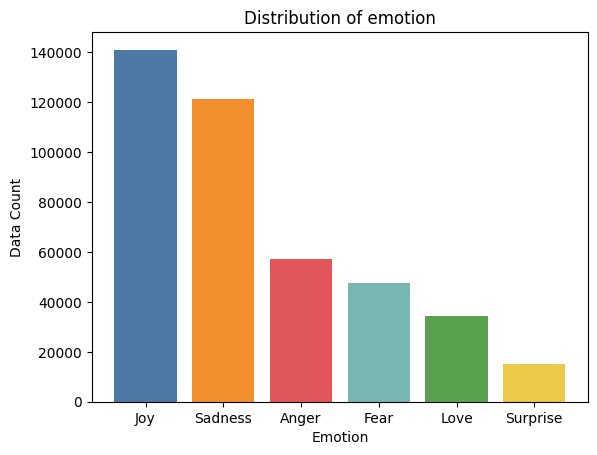

In [8]:
source_counts = emotions_data['emotion_name'].value_counts()

colors = ['#4e79a7', '#f28e2c', '#e15759', '#76b7b2', '#59a14f', 
          '#edc949', '#af7aa1', '#ff9da7', '#9c755f', '#bab0ab']

plt.bar(source_counts.index, source_counts.values, color=colors[:len(source_counts)])
plt.title('Distribution of emotion')
plt.xlabel('Emotion')
plt.ylabel('Data Count')
plt.show()

In [9]:
emotions_data['label'].value_counts()

label
1    141067
0    121187
3     57317
4     47712
2     34554
5     14972
Name: count, dtype: int64

In [23]:
emotions_data = emotions_data.rename(columns={'label': 'polarity'})
emotions_data['source'] = 'Twitter'
emotions_data.head()

,text,polarity,source
0,i just feel really helpless and heavy hearted,4,Twitter
1,ive enjoyed being able to slouch about relax a...,0,Twitter
2,i gave up my internship with the dmrg and am f...,4,Twitter
3,i dont know i feel so lost,0,Twitter
4,i am a kindergarten teacher and i am thoroughl...,4,Twitter


In [24]:
emotions_data['text'] = emotions_data['text'].apply(clean_tweet)
emotions_data.head()

,text,polarity,source
0,i just feel really helpless and heavy hearted,4,Twitter
1,ive enjoyed being able to slouch about relax a...,0,Twitter
2,i gave up my internship with the dmrg and am f...,4,Twitter
3,i dont know i feel so lost,0,Twitter
4,i am a kindergarten teacher and i am thoroughl...,4,Twitter


In [29]:
from transformers import BertTokenizer

tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# Compute token lengths
def compute_token_length(text):
    encoded = tokenizer.encode(text, add_special_tokens=True)
    return len(encoded)

emotions_data['token_length'] = emotions_data['text'].apply(compute_token_length)

In [30]:
# Count entries exceeding thresholds
execeed_0 = len(emotions_data[emotions_data['token_length'] > 0])
exceed_100 = len(emotions_data[emotions_data['token_length'] > 100])
exceed_200 = len(emotions_data[emotions_data['token_length'] > 200])
exceed_300 = len(emotions_data[emotions_data['token_length'] > 300])
exceed_400 = len(emotions_data[emotions_data['token_length'] > 400])
exceed_500 = len(emotions_data[emotions_data['token_length'] > 500])

print(f"Number of entries exceeding 0 tokens: {execeed_0}")
print(f"Number of entries exceeding 100 tokens: {exceed_100}")
print(f"Number of entries exceeding 200 tokens: {exceed_200}")
print(f"Number of entries exceeding 300 tokens: {exceed_300}")
print(f"Number of entries exceeding 400 tokens: {exceed_400}")
print(f"Number of entries exceeding 500 tokens: {exceed_500}")

Number of entries exceeding 0 tokens: 416809
Number of entries exceeding 100 tokens: 6
Number of entries exceeding 200 tokens: 0
Number of entries exceeding 300 tokens: 0
Number of entries exceeding 400 tokens: 0
Number of entries exceeding 500 tokens: 0


In [32]:
emotions_data.to_csv('Datasets/Cleaned with tokens/emotions_dataset.csv', encoding='utf-8', index=False)

# goEmotions Dataset

In [10]:
goemotions = datasets.load_dataset("go_emotions")
goemotions_train = pd.DataFrame(goemotions['train'])
goemotions_val = pd.DataFrame(goemotions['validation'])
goemotions_test = pd.DataFrame(goemotions['test'])

In [11]:
def filter_single_label(df):
    df = df[df['labels'].apply(lambda x: len(x) == 1)]
    new_df = df.copy()
    new_df['labels'] = df['labels'].apply(lambda x: x[0])
    new_df = new_df.drop(['id'], axis=1)
    return new_df

goemotions_train = filter_single_label(goemotions_train)
goemotions_val = filter_single_label(goemotions_val)
goemotions_test = filter_single_label(goemotions_test)

print(f"Train size: {len(goemotions_train)}")
print(f"Validation size: {len(goemotions_val)}")
print(f"Test size: {len(goemotions_test)}")

Train size: 36308
Validation size: 4548
Test size: 4590


In [14]:
goemotions_train['text'] = goemotions_train['text'].apply(clean_reddit_comment)
goemotions_val['text'] = goemotions_val['text'].apply(clean_reddit_comment)
goemotions_test['text'] = goemotions_test['text'].apply(clean_reddit_comment)

goemotions_train.replace(to_replace=r'\[name\]', value='someone', regex=True, inplace=True)
goemotions_val.replace(to_replace=r'\[name\]', value='someone', regex=True, inplace=True)
goemotions_test.replace(to_replace=r'\[name\]', value='someone', regex=True, inplace=True)

In [15]:
def clean_empty_text(df, text_column='text', verbose=True):
    df_copy = df.copy()
    
    df_copy['is_text_empty'] = df_copy[text_column].apply(lambda x: pd.isnull(x) or x == "")
    
    empty_text_count = df_copy['is_text_empty'].sum()
    
    if verbose:
        print(f"Total number of empty or NaN entries in '{text_column}' column: {empty_text_count}")
        print(f"Shape of dataset before removing empty entries: {df_copy.shape}")
    
    df_cleaned = df_copy[df_copy[text_column].notna() & (df_copy[text_column] != "")]
    
    df_cleaned = df_cleaned.drop(['is_text_empty'], axis=1)
    
    if verbose:
        print(f"Shape of dataset after removing empty entries: {df_cleaned.shape}")
        print(f"Removed {empty_text_count} rows")
    
    return df_cleaned

In [16]:
goemotions_train = clean_empty_text(goemotions_train)
goemotions_val = clean_empty_text(goemotions_val)
goemotions_test = clean_empty_text(goemotions_test)

Total number of empty or NaN entries in 'text' column: 2
Shape of dataset before removing empty entries: (36308, 3)
Shape of dataset after removing empty entries: (36306, 2)
Removed 2 rows
Total number of empty or NaN entries in 'text' column: 0
Shape of dataset before removing empty entries: (4548, 3)
Shape of dataset after removing empty entries: (4548, 2)
Removed 0 rows
Total number of empty or NaN entries in 'text' column: 1
Shape of dataset before removing empty entries: (4590, 3)
Shape of dataset after removing empty entries: (4589, 2)
Removed 1 rows


In [17]:
# Find number of unique labels

print("Number of unique labels in GoEmotions dataset:")
print(f"Train: {goemotions_train['labels'].nunique()}")
print(f"Validation: {goemotions_val['labels'].nunique()}")
print(f"Test: {goemotions_test['labels'].nunique()}")

Number of unique labels in GoEmotions dataset:
Train: 28
Validation: 28
Test: 28


In [18]:
# Check label distribution in each dataset

# Combine the 3 datasets into 1
goemotions_combined_df = pd.concat([goemotions_train, goemotions_val, goemotions_test])

# Reset index to avoid duplicate indices
goemotions_combined_df = goemotions_combined_df.reset_index(drop=True)

# Display information about the combined dataset
print(f"Shape of combined dataset: {goemotions_combined_df.shape}")
goemotions_combined_df.head()

Shape of combined dataset: (45443, 2)


,text,labels
0,my favourite food is anything i didn't have to...,27
1,"now if he does off himself, everyone will thin...",27
2,why the fuck is bayless isoing,2
3,to make her feel threatened,14
4,dirty southern wankers,3


In [19]:
goemotions_combined_df['labels'].value_counts()

labels
27    16018
0      3384
15     2378
4      2367
1      2046
3      1809
10     1809
18     1760
7      1729
2      1265
20     1087
6      1057
17     1052
25     1003
26      902
9       888
5       831
22      749
11      635
13      619
14      553
8       497
24      437
12      246
19      105
23      103
21       67
16       47
Name: count, dtype: int64

In [20]:
from transformers import BertTokenizer

tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# Compute token lengths
def compute_token_length(text):
    encoded = tokenizer.encode(text, add_special_tokens=True)
    return len(encoded)

goemotions_combined_df['token_length'] = goemotions_combined_df['text'].apply(compute_token_length)

In [21]:
# Count entries exceeding thresholds
exceed_0 = len(goemotions_combined_df[goemotions_combined_df['token_length'] > 0])
exceed_100 = len(goemotions_combined_df[goemotions_combined_df['token_length'] > 100])
exceed_200 = len(goemotions_combined_df[goemotions_combined_df['token_length'] > 200])
exceed_300 = len(goemotions_combined_df[goemotions_combined_df['token_length'] > 300])
exceed_400 = len(goemotions_combined_df[goemotions_combined_df['token_length'] > 400])
exceed_500 = len(goemotions_combined_df[goemotions_combined_df['token_length'] > 500])

print(f"Number of entries exceeding 0 tokens: {exceed_0}")
print(f"Number of entries exceeding 100 tokens: {exceed_100}")
print(f"Number of entries exceeding 200 tokens: {exceed_200}")
print(f"Number of entries exceeding 300 tokens: {exceed_300}")
print(f"Number of entries exceeding 400 tokens: {exceed_400}")
print(f"Number of entries exceeding 500 tokens: {exceed_500}")

Number of entries exceeding 0 tokens: 45443
Number of entries exceeding 100 tokens: 0
Number of entries exceeding 200 tokens: 0
Number of entries exceeding 300 tokens: 0
Number of entries exceeding 400 tokens: 0
Number of entries exceeding 500 tokens: 0


In [42]:
goemotions_train.to_csv('Datasets/goemotions/goemotions_train.csv', encoding='utf-8', index=False)
goemotions_val.to_csv('Datasets/goemotions/goemotions_val.csv', encoding='utf-8', index=False)
goemotions_test.to_csv('Datasets/goemotions/goemotions_test.csv', encoding='utf-8', index=False)